# Speaker identification using VGG Classiffier 

This notebook tests applies static image (frame-by-frame) face detection for speaker re-identification in videos and demostrates that state of the art face detection techniques are deceived by fake videos that use face swapping techniques. Reference for VGG model implementation in Python: https://github.com/rcmalli/keras-vggface

In [2]:
#Importing Packages
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import dlib
import cv2
import random
from keras.preprocessing import image
from keras_vggface import utils
from keras_vggface.vggface import VGGFace
import imutils
#import utils.pre_proc_utils as utilities
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

from test import * #Utility function to read data from tfrecords



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Speaker Identification using VGGFace classifier on a FakeVideo

In [4]:
#'/home/ubuntu/fakebusters/data/'+mode+'/tf_records/'+p
#labels_dic = {'putin':5 ,'warren': 6, 'justin' : 2, 'may' : 7, 'modi' : 8, 'trump': 4, 'hillary': 1, 'obama': 9, 'pelosi' : 3, 'bernie' : 10, 'michelle' : 11, 'biden': 0}
people=['putin','warren','justin', 'may', 'modi', 'trump', 'hillary', 'obama', 'pelosi', 'bernie', 'michelle', 'biden']
lb=LabelBinarizer()
lb.fit(people)

print(labels_o)

[[0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0]]


In [1]:
# Image pre-processing function
def pre_process(images):
  processed_images = []
  for n in range(images.shape[0]):
    image = images[n]
    image = cv2.resize(image,  (int(224 * (image_width * 1.0 / image_height)) + 1 , 224))
    image = image[:224, 87 : 87 + 224,:]
    image = np.array(image, dtype=np.float32)
    for i in range(3):
      image[:,:,i] -= means[i]
    processed_images.append(image)
  processed_images = np.array(processed_images, dtype=np.float32)
  return processed_images

In [33]:
# Example for data generationg function - https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
# Data Generation Function 

def mem_load(input_path,people,n_frames,mode="train"): 
    
    seq_collection=[]
    label_collection=[]
    lb=LabelBinarizer()
    lb.fit(people)
    
    for person in people:
        
        # Load Videos
        person_videos=[]
        file_path=[input_path+mode+'/tf_records/'+person+'_'+mode+'.tfrecords']
        num_videos,videos=get_number_of_records(file_path, n_frames)
        seq_collection.append([videos])
        
        # Load Labels
        person_labels=[person]*num_videos
        person_onehot=lb.transform(person_labels)
        label_collection.append([person_onehot])
        
    return np.array(seq_collection),np.array(label_collection)
        

'''

def data_gen(seq_collection,label_collection, bs,n_frames,mode="train", aug=None):
   

    # loop indefinitely (to use yield instead of return?)
    while True:
        # initialize our batches of images and labels
        sequences = [] #(each sequence has 32 frames of size 70x70x3)
        labels = []
        lb=LabelBinarizer()
        
        
        if mode=='train':
    
        # keep looping until we reach our batch size
            while len(sequences) < bs:
                print('enter_loop')
                # Select person at random and retrieve tf records
                person=random.choice(people)
                
          
                # Select sequence at random from person and append sequence and label
                video_ix=np.random.randint(num_videos,size=1)[0]
                sequence=videos[video_ix]
                sequences.append(sequence)
                labels.append(person)
                print(len(sequences))

            # one-hot encode the labels
            labels = lb.transform(np.array(labels))
        
            # if the data augmentation object is not None, apply it (A good data augmentation would allow the classifier to be more robust to permutations)
            if aug is not None:
                (images, labels) = next(aug.flow(np.array(images),
                    labels, batch_size=bs))
            
                
            
        # yield the batch to the calling function
        yield (np.array(sequences), labels)
'''

'\n\ndef data_gen(seq_collection,label_collection, bs,n_frames,mode="train", aug=None):\n   \n\n    # loop indefinitely (to use yield instead of return?)\n    while True:\n        # initialize our batches of images and labels\n        sequences = [] #(each sequence has 32 frames of size 70x70x3)\n        labels = []\n        lb=LabelBinarizer()\n        \n        \n        if mode==\'train\':\n    \n        # keep looping until we reach our batch size\n            while len(sequences) < bs:\n                print(\'enter_loop\')\n                # Select person at random and retrieve tf records\n                person=random.choice(people)\n                \n          \n                # Select sequence at random from person and append sequence and label\n                video_ix=np.random.randint(num_videos,size=1)[0]\n                sequence=videos[video_ix]\n                sequences.append(sequence)\n                labels.append(person)\n                print(len(sequences))\n\n 

In [34]:
# Test Data generating function

# Train mode
input_path='/Users/dsrincon/Dropbox/Personal/EDU/Posgrado/masters_usa/MIMS/2019-I/cs282_deep_neural_networks/assignments/project/data/'
bs=12
n_frames=32
#yield_tuple=next(data_gen(input_path,people,lb, bs,n_frames,mode="train", aug=None))
#batch_sequences=yield_tuple[0]
#batch_labels=yield_tuple[1]
#print(batch_sequences.shape)
print(mem_load(input_path,people,n_frames,mode="train")[0].shape)

(12, 1)


In [4]:
# Initialize VGGFace Model with resnet50 architecture (State of the art as of 2017)
model = VGGFace(model='resnet50')

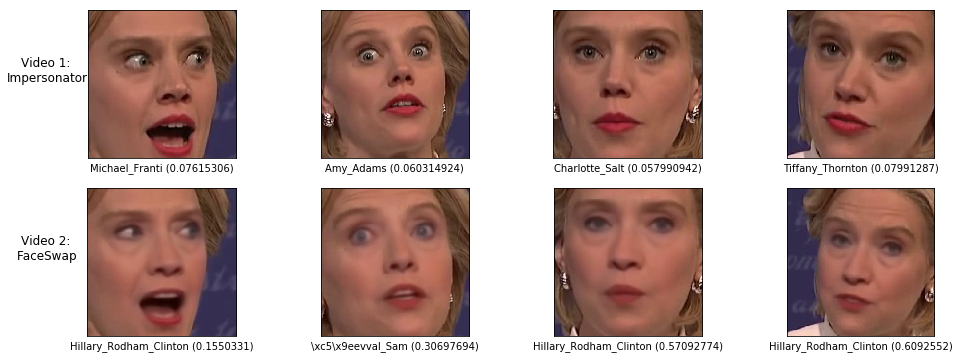

In [7]:
# ---SHOW IMPOSTOR VS. FACESWAP

# Sample random frames
sample_size=4
no_frames=min(impostor_frames.shape[0],faceswap_frames.shape[0])
sample_index=np.random.randint(no_frames, size=(sample_size,))
sample_imp_frames=[]
sample_fs_frames=[]


f, ax= plt.subplots(2,sample_size)

ax[:,0][0].set_ylabel('Video 1: \nImpersonator', rotation=0, size='large')
ax[:,0][1].set_ylabel('Video 2: \nFaceSwap', rotation=0, size='large')
ax[:,0][0].yaxis.labelpad = 40
ax[:,0][1].yaxis.labelpad = 40
f.set_size_inches(16, 6)



detector = dlib.get_frontal_face_detector()


for i in range(sample_size):
    
    
    # Impostor - Exctract face from frame
    impostor_image=impostor_frames[sample_index[i]]
    gray = cv2.cvtColor(impostor_image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)

    right=int(rects[0].left())
    left=int(rects[0].right())
    top=int(rects[0].top())
    bottom=int(rects[0].bottom())
    
    impostor_image=impostor_image[top:bottom,right:left,:]
    sample_imp_frames.append(impostor_image)
    
    # FaceSwap - Exctract face from frame
    faceswap_image=faceswap_frames[sample_index[i]]
    gray = cv2.cvtColor(faceswap_image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)

    right=int(rects[0].left())
    left=int(rects[0].right())
    top=int(rects[0].top())
    bottom=int(rects[0].bottom())
    
    faceswap_image=faceswap_image[top:bottom,right:left,:]
    sample_fs_frames.append(faceswap_image)
    
    # Classify Impostor
    impostor_frames_i=np.array(sample_imp_frames[i],dtype=np.float64)
    impostor_frames_i = cv2.resize(impostor_frames_i, dsize=(224,224))
    impostor_frames_i = np.expand_dims(impostor_frames_i, axis=0)
    preds_imp = model.predict(impostor_frames_i)
    preds_imp=utils.decode_predictions(preds_imp)

    # Classify FaceSwap
    faceswap_frames_i=np.array(sample_fs_frames[i],dtype=np.float64)
    faceswap_frames_i = cv2.resize(faceswap_frames_i, dsize=(224,224))
    faceswap_frames_i = np.expand_dims(faceswap_frames_i, axis=0)
    preds_fs = model.predict(faceswap_frames_i)
    preds_fs=utils.decode_predictions(preds_fs)
 
    
    # Plot each frame sampled
    impostor_image=cv2.cvtColor(sample_imp_frames[i], cv2.COLOR_BGR2RGB)
    faceswap_image=cv2.cvtColor(sample_fs_frames[i], cv2.COLOR_BGR2RGB)
    
    ax[0,i].imshow(impostor_image)
    ax[1,i].imshow(faceswap_image)
    
    # Format Plots
    ax[:,i][0].set_yticks([])
    ax[:,i][0].set_xticks([])
    ax[:,i][1].set_yticks([])
    ax[:,i][1].set_xticks([])
    
    # Add Classifications and Softmax values
    ax[:,i][0].set_xlabel(preds_imp[0][0][0][3:-1]+" ("+str(preds_imp[0][0][1])+")")
    ax[:,i][1].set_xlabel(preds_fs[0][0][0][3:-1]+" ("+str(preds_fs[0][0][1])+")")
    
    
   
    
    






In [ ]:
# ----PERFORM IDENTIFICATION USING 
# -Get Frames

start=time.time()
impostor_video='/Users/dsrincon/Dropbox/Personal/EDU/Posgrado/masters_usa/MIMS/2019-I/cs282_deep_neural_networks/assignments/project/cs282/models/raw_pixels/test_vid/f205q1XQs78_0.mp4'
impostor_frames=utilities.video_to_frame(impostor_video)
end=time.time()
print('Duration:{}'.format(end-start))